In [1]:
!pip install pyspark


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.functions import split, explode, col, lower, sort_array
import pyspark.sql.functions as F
import pyspark.sql.dataframe
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import types
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [3]:
spark = pyspark.sql.SparkSession.builder.config("spark.executor.memory", "16g").config("spark.driver.memory", "16g").getOrCreate()

In [5]:
dfs = spark.read.csv('afterCleaning.csv', sep=',', inferSchema=True, header=True, multiLine=True)

In [6]:
# rename the columns because it contains space
renameing =(col.replace(' ', '_') for col in dfs.columns)
dfs = dfs.toDF(*renameing)
dfs.show(5)

+---+--------------+--------+------------------+----------+----------+--------------+-----------------+------------+------------+------------+------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+----------------+---------------------------------+------------+-----------+-------------------+------------+--------------------+------------------+-------------+------------+-------------------+---------------------+-----------------------+
|_c0|Summons_Number|Plate_ID|Registration_State|Plate_Type|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Street_Code1|Street_Code2|Street_Code3|Violation_Location|Violation_Precinct|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_Time|Violation_County|Violation_In_Front_Of_Or_Opposite|House_Number|Street_Name|Date_First_Observed|Sub_Division|From_Hours_In_Effect|To_Hours_In_Effect|Vehicle_Color|Vehicle_Year|Violation_Post_Code|Violation_Description|Vehicle_Exp

# EDA

### 1st plot insight

##### This plot shows the 20 highest Violation times.  As you can see, all the times are in the morning. the highest one at 8:36 AM and the lowest at 8:42 AM, probably because it's work time for most people. As a plan of action, we can set up a system for people who want to book ahead of time and pay a higher price.

In [7]:
dfs.registerTempTable('Temp1') 
Temp1 = spark.sql(r"""SELECT Violation_Time, COUNT(Violation_Time) AS CounV
                                                FROM Temp1 GROUP BY Violation_Time
                                                ORDER BY CounV DESC
                                                LIMIT 20""") 
Temp1 = Temp1.toPandas() 

C:\Users\abu3a\miniconda3\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


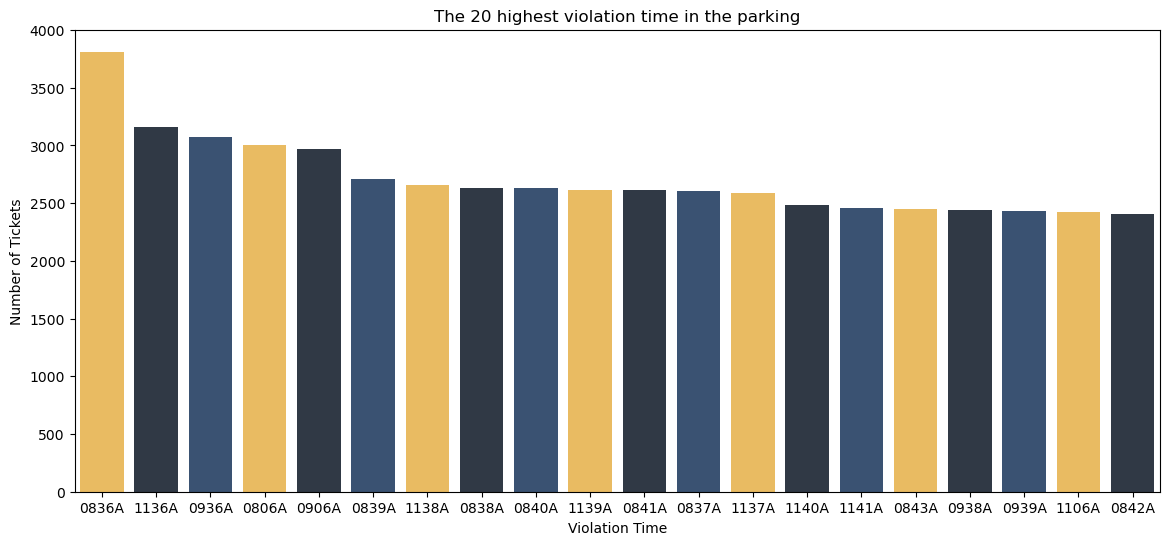

In [8]:
plt.figure(figsize=(14, 6))
sns.barplot(x=Temp1["Violation_Time"],y=Temp1['CounV'], palette=['#FFC24C','#2c3848','#31507B'] )
plt.title('The 20 highest violation time in the parking')
plt.xlabel('Violation Time')
plt.ylabel('Number of Tickets')
plt.show() 

### 2nd plot insights 
##### This plot shows the 10 highest vehicle Make in the parking. As can be seen, Ford ranks first, followed by Toyota and Honda. 

In [ ]:
dfs.registerTempTable('Temp2') 
Temp2 = spark.sql(r"""SELECT Vehicle_Make, COUNT(Vehicle_Make) AS NumberOfTickets
                                                FROM Temp2 GROUP BY Vehicle_Make
                                                ORDER BY NumberOfTickets DESC
                                                LIMIT 10""") 
Temp2 = Temp2.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


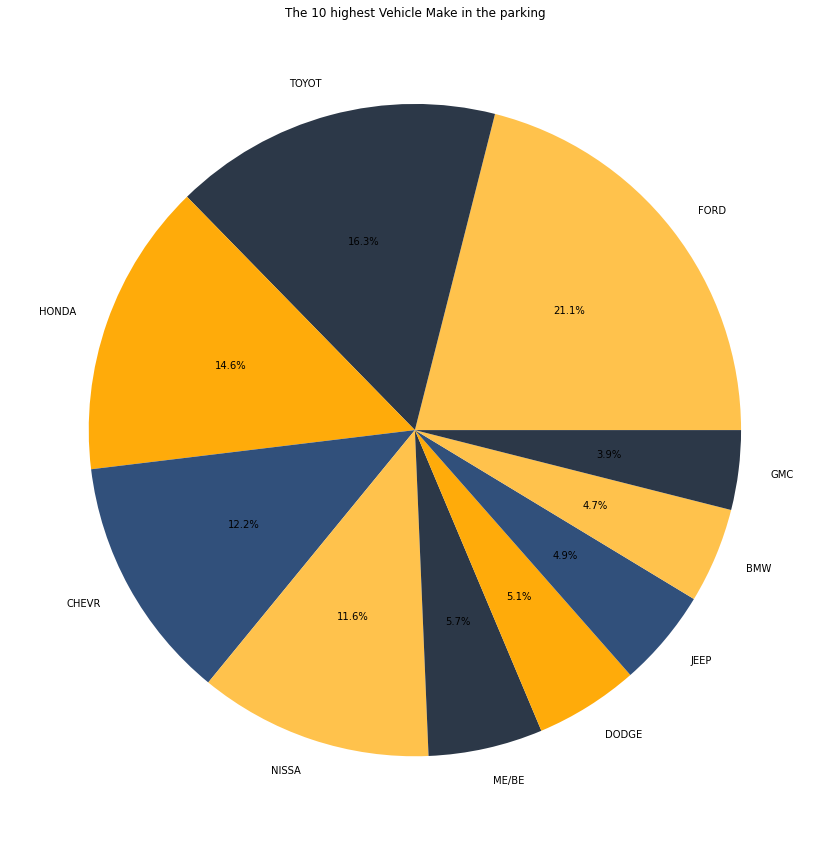

In [ ]:
plt.figure(figsize=(20, 15))
plt.pie(Temp2['NumberOfTickets'], labels = Temp2['Vehicle_Make'], autopct='%1.1f%%',colors=['#FFC24C','#2c3848','#FFAB0A', '#31507B'])
plt.title('The 10 highest Vehicle Make in the parking')
plt.show() 

### 3rd plot insights 
##### This plot shows the violation County with the number of tickets and the place where the ticket was issued (front, opposite). the higest County in Violation is NY and the Violation in all County is in front.

In [ ]:
dfs.registerTempTable('Temp3') 
Temp3 = spark.sql(r"""SELECT Violation_County, Violation_In_Front_Of_Or_Opposite
                      FROM Temp3 """) 
Temp3 = Temp3.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


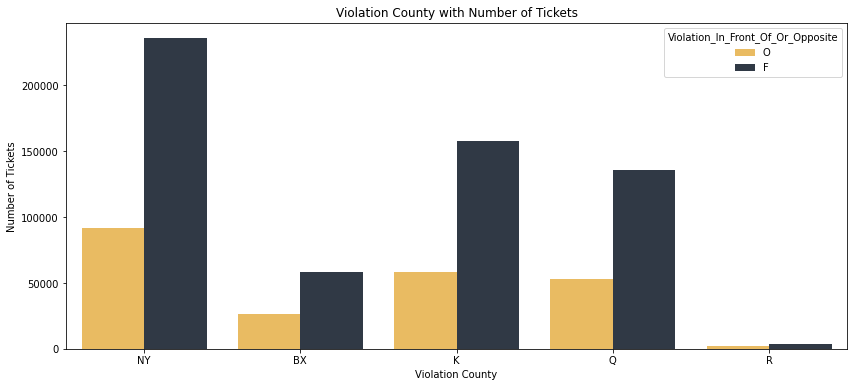

In [ ]:
from matplotlib import colors
plt.figure(figsize=(14, 6))
sns.countplot(x=Temp3['Violation_County'], hue= Temp3['Violation_In_Front_Of_Or_Opposite'], palette=['#FFC24C','#2c3848','#bebab9'] )
plt.title('Violation County with Number of Tickets')
plt.xlabel('Violation County')
plt.ylabel('Number of Tickets')
plt.show() 

### 4th plot insights 
#### This plot shows the number of Violation Precinct, most Violation are between 20 to 90.

In [ ]:
dfs.registerTempTable('Temp4') 
Temp4 = spark.sql(r"""SELECT Violation_Precinct
                      FROM Temp4 """) 
Temp4 = Temp4.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


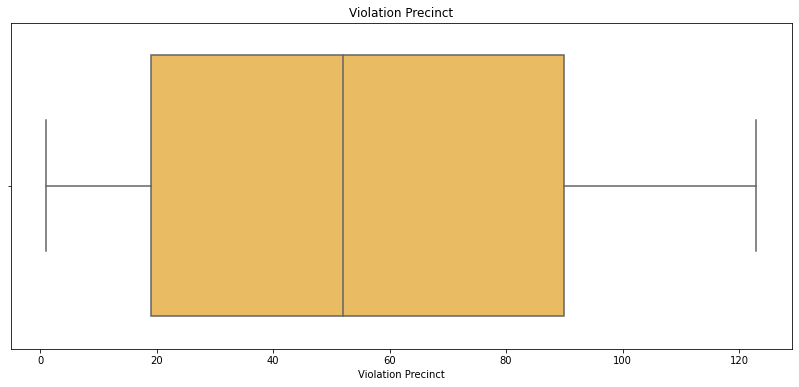

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(x= Temp4['Violation_Precinct'], color = '#FFC24C')
plt.xlabel('Violation Precinct')
plt.title('Violation Precinct')
plt.show() 

### 5th plot insights 
#### This plot shows the top 10 years by the percentage of tickets as you can see 2015 is the highest year then 2016.

In [ ]:
dfs.registerTempTable('Temp5') 
Temp5 = spark.sql(r"""SELECT Vehicle_Year
                      FROM Temp5 """) 
Temp5 = Temp5.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


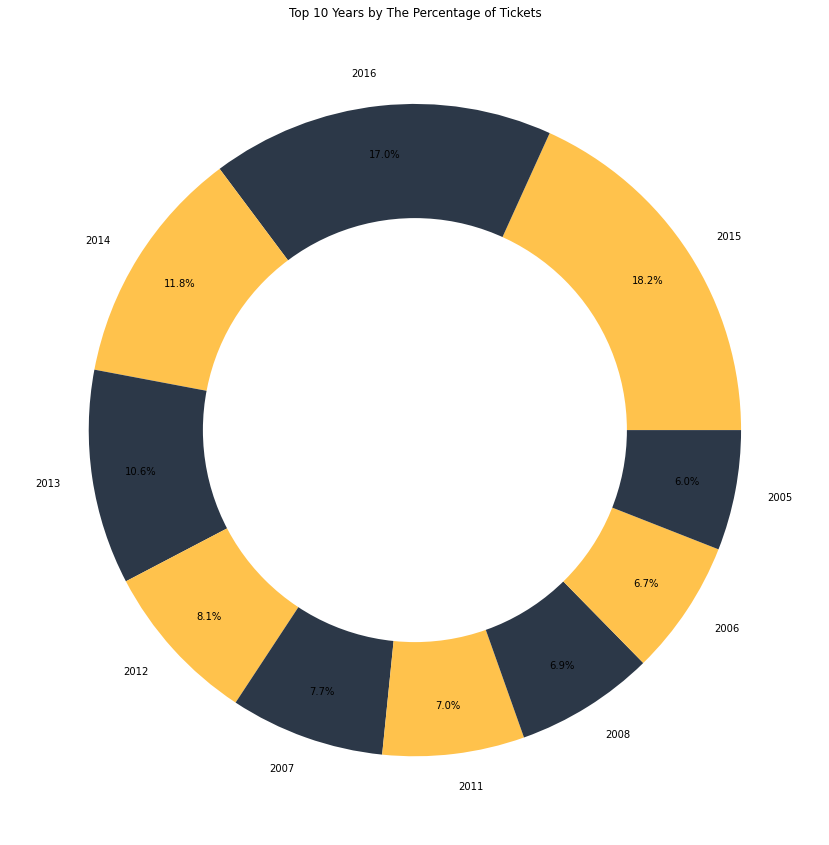

In [ ]:
Vehicle_Year_count = Temp5.Vehicle_Year.value_counts().sort_values().nlargest(10)
plt.figure(figsize=(20, 15))
plt.title('Top 10 Years by The Percentage of Tickets')
plt.pie(Vehicle_Year_count.values, labels=Vehicle_Year_count.index, autopct='%1.1f%%', pctdistance=0.85,colors=['#FFC24C','#2c3848'])
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

### 6th plot insights 
#### This plot shows the issue date and number of tickets. In general, 2017 and 2016 are the highest years to issue tickets. In 2016, the 25th of November was the highest day for ticket sales, with over 7,500 issued.

In [ ]:
dfs.registerTempTable('Temp6') 
Temp6 = spark.sql(r"""SELECT Issue_Date
                      FROM Temp6 """) 
Temp6 = Temp6.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


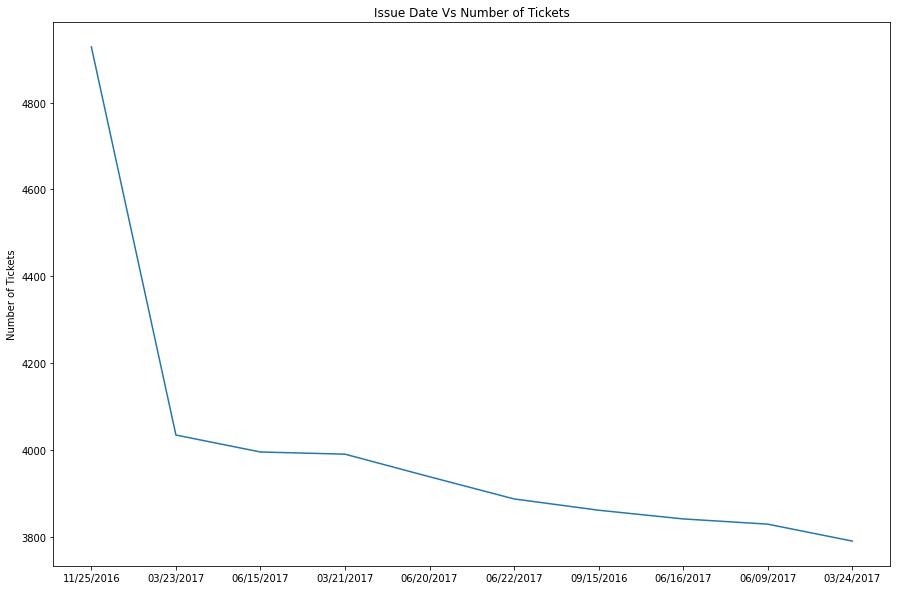

In [ ]:
Issue_Date_count = Temp6.Issue_Date.value_counts().sort_values().nlargest(10)
plt.figure(figsize=(15,10))
sns.lineplot(x = Issue_Date_count.index, y = Issue_Date_count.values)
plt.title("Issue Date Vs Number of Tickets")
plt.ylabel('Number of Tickets')
plt.show()

### 7th plot insights 
#### This plot shows the top 4 Plate Type and number of tickets. PAS is the highest then COM, OMT, OMS.



In [ ]:
dfs.registerTempTable('Temp7') 
Temp7 = spark.sql(r"""SELECT Plate_Type
                      FROM Temp7 """) 
Temp7 = Temp7.toPandas() 
Plate_Type_count = Temp7.Plate_Type.value_counts().sort_values().nlargest(4)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Text(0.5, 0, 'Number of Tickets')

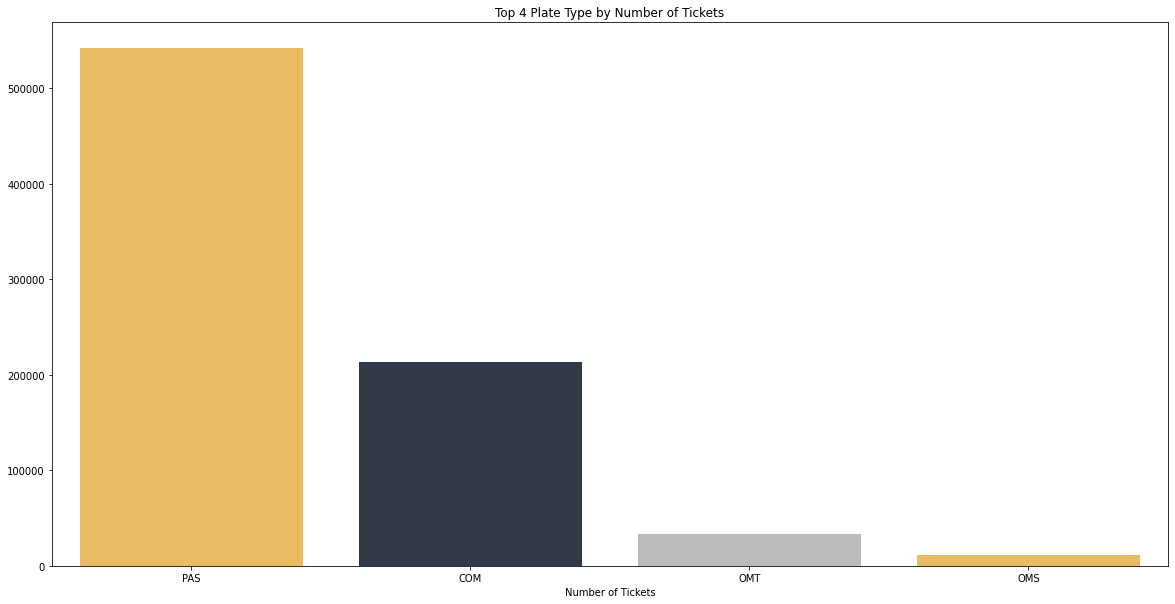

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=Plate_Type_count.index,
              y=Plate_Type_count.values,palette=['#FFC24C','#2c3848','#bebab9'] )
plt.title("Top 4 Plate Type by Number of Tickets")
plt.xlabel('Number of Tickets')

### 8th plot insights 
##### This plot shows the top 10 violations by description and summons number. the highest Violation is 21 (No Parking). This might be due to the low cost of this violation, and to solve this problem, we recommend increasing the cost.

In [ ]:
dfs.registerTempTable('Temp8') 
Temp8 = spark.sql(r"""SELECT Violation_Description, Summons_Number
                      FROM Temp8""") 
Temp8 = Temp8.toPandas()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Text(0, 0.5, 'Violation Description')

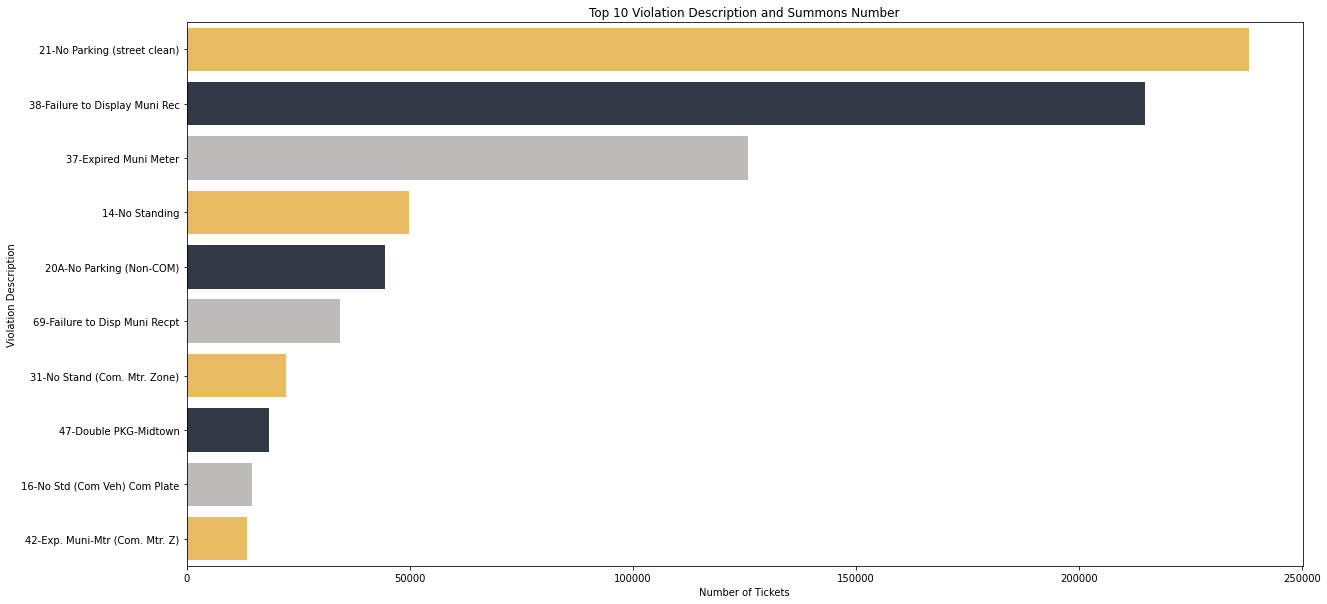

In [ ]:
plt.figure(figsize=(20,10))
# Top 10 Violations dataframe
top_10_violations = Temp8.groupby(['Violation_Description']).count()['Summons_Number'].reset_index().sort_values('Summons_Number',ascending = False).head(10)
# Bar plot
sns.barplot(x = 'Summons_Number', y = 'Violation_Description', data = top_10_violations,palette=['#FFC24C','#2c3848','#bebab9' ])
plt.title("Top 10 Violation Description and Summons Number")
plt.xlabel('Number of Tickets')
plt.ylabel('Violation Description')

### 9th plot insights 
#### This plot shows the top 10 vehicle models in 2015. We chose 2015 because it was the most successful year in terms of ticket sales. the highest Make was Toyot with more than 16,000 Tickets.


In [ ]:
dfs.registerTempTable('Temp9')
Temp9 = spark.sql(r"""SELECT Vehicle_Year, Vehicle_Make
                      FROM Temp9
                      WHERE Vehicle_Year == 2015 """) 
Temp9 = Temp9.toPandas()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
grouped=Temp9.copy()
grouped = grouped.groupby('Vehicle_Make')\
.agg({'Vehicle_Make': [('col1', 'count')] }).reset_index()
grouped.columns = ['Vehicle_Make','Vehicle_count']
grouped = grouped.sort_values(by=['Vehicle_count'], ascending=False).reset_index(drop=True)
grouped = grouped.head(10)

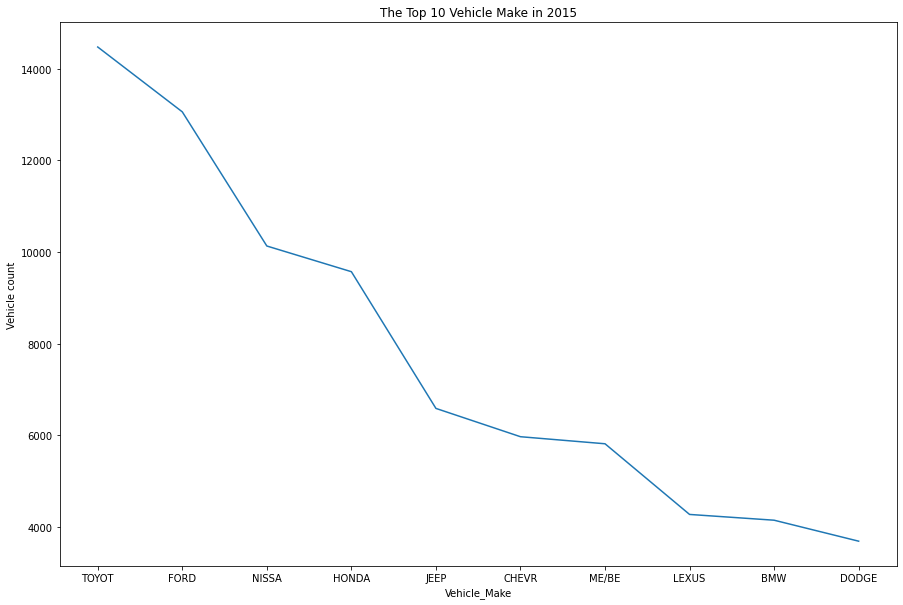

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(x = 'Vehicle_Make', y = 'Vehicle_count', data = grouped)
plt.title("The Top 10 Vehicle Make in 2015")
plt.ylabel('Vehicle count')
plt.show()

### 10th plot insights 
#### This plot shows the violation of the place where the ticket was issued (front, opposite). front is the highest with 62.9%

##### Also, this is going to be our target column for the classification problem, and it has a skew class distribution, so we will deal with that with some techniques.

In [ ]:
dfs.registerTempTable('Temp10') 
Temp10 = spark.sql(r"""SELECT Violation_In_Front_Of_Or_Opposite
                      FROM Temp10 """) 
Temp10 = Temp10.toPandas() 

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


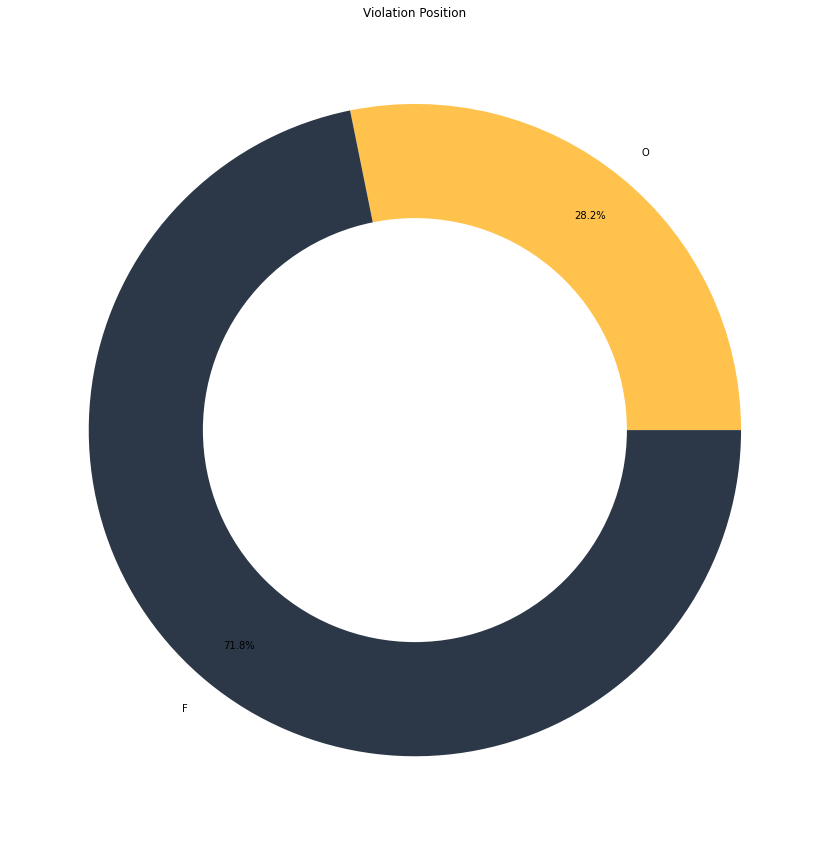

In [ ]:
Violation_In_Front_Of_Or_Opposite_count = Temp10.Violation_In_Front_Of_Or_Opposite.value_counts().sort_values()

plt.figure(figsize=(20, 15))
plt.title('Violation Position')
plt.pie(Violation_In_Front_Of_Or_Opposite_count.values, labels=Violation_In_Front_Of_Or_Opposite_count.index, autopct='%1.1f%%', pctdistance=0.85,colors=['#FFC24C','#2c3848','#bebab9'])
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)

***
# ML Classification Section 

***

## Feature Engineering and Feature Selection

In [9]:
# drop some columns 
col = ['Issue_Date','Violation_Time','From_Hours_In_Effect','To_Hours_In_Effect','Plate_ID']
dfs = dfs.drop(*col)
dfs.show()

+---+--------------+------------------+----------+--------------+-----------------+------------+------------+------------+------------+------------------+------------------+---------------+-----------+--------------+------------+----------------+---------------------------------+------------+------------+-------------------+------------+-------------+------------+-------------------+---------------------+-----------------------+
|_c0|Summons_Number|Registration_State|Plate_Type|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Street_Code1|Street_Code2|Street_Code3|Violation_Location|Violation_Precinct|Issuer_Precinct|Issuer_Code|Issuer_Command|Issuer_Squad|Violation_County|Violation_In_Front_Of_Or_Opposite|House_Number| Street_Name|Date_First_Observed|Sub_Division|Vehicle_Color|Vehicle_Year|Violation_Post_Code|Violation_Description|Vehicle_Expiration_year|
+---+--------------+------------------+----------+--------------+-----------------+------------+------------+------------+------------

In [10]:
# encode all the categorical columns using StringIndexer and drop the original columns.
cat_columns = ['Registration_State','Plate_Type','Vehicle_Body_Type','Vehicle_Make','Issuer_Command','Sub_Division',
               'Issuer_Squad','Violation_County','Violation_In_Front_Of_Or_Opposite','Street_Name','Vehicle_Color','Violation_Post_Code','Violation_Description']


for col in cat_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    dfs = indexer.fit(dfs).transform(dfs)
    
dfs = dfs.drop(*cat_columns)
#dfs.show()

In [11]:
dfs.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Summons_Number: long (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Street_Code1: integer (nullable = true)
 |-- Street_Code2: integer (nullable = true)
 |-- Street_Code3: integer (nullable = true)
 |-- Violation_Location: integer (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Issuer_Code: integer (nullable = true)
 |-- House_Number: string (nullable = true)
 |-- Date_First_Observed: integer (nullable = true)
 |-- Vehicle_Year: integer (nullable = true)
 |-- Vehicle_Expiration_year: integer (nullable = true)
 |-- Registration_State_idx: double (nullable = false)
 |-- Plate_Type_idx: double (nullable = false)
 |-- Vehicle_Body_Type_idx: double (nullable = false)
 |-- Vehicle_Make_idx: double (nullable = false)
 |-- Issuer_Command_idx: double (nullable = false)
 |-- Sub_Division_idx: double (nullable = false)
 |-- Issuer_Squad_idx: double (nullab

In [12]:
# change the columns data type 
from pyspark.sql.types import IntegerType
  
dfs = dfs \
  .withColumn("House_Number",
              dfs["House_Number"]
              .cast(IntegerType()))    \
      .withColumn("Violation_In_Front_Of_Or_Opposite_idx",
              dfs["Violation_In_Front_Of_Or_Opposite_idx"]
              .cast(IntegerType()))    \
      .withColumn("Summons_Number",
              dfs["Summons_Number"]
              .cast(IntegerType()))    \
      .withColumn("Registration_State_idx",
              dfs["Registration_State_idx"]
              .cast(IntegerType()))    \
      .withColumn("Plate_Type_idx",
              dfs["Plate_Type_idx"]
              .cast(IntegerType()))    \
      .withColumn("Vehicle_Body_Type_idx",
              dfs["Vehicle_Body_Type_idx"]
              .cast(IntegerType()))    \
      .withColumn("Vehicle_Make_idx",
              dfs["Vehicle_Make_idx"]
              .cast(IntegerType()))    \
      .withColumn("Issuer_Command_idx",
              dfs["Issuer_Command_idx"]
              .cast(IntegerType()))    \
      .withColumn("Sub_Division_idx",
              dfs["Sub_Division_idx"]
              .cast(IntegerType()))    \
      .withColumn("Issuer_Squad_idx",
              dfs["Issuer_Squad_idx"]
              .cast(IntegerType()))    \
      .withColumn("Violation_County_idx",
              dfs["Violation_County_idx"]
              .cast(IntegerType()))    \
      .withColumn("Street_Name_idx",
              dfs["Street_Name_idx"]
              .cast(IntegerType()))    \
      .withColumn("Vehicle_Color_idx",
              dfs["Vehicle_Color_idx"]
              .cast(IntegerType()))    \
      .withColumn("Violation_Post_Code_idx",
              dfs["Violation_Post_Code_idx"]
              .cast(IntegerType()))    \
      .withColumn("Violation_Description_idx",
              dfs["Violation_Description_idx"]
              .cast(IntegerType()))    \

  

In [13]:
# drop the null value 
dfs = dfs.na.drop()

# Case1: Target column is Violation_In_Front_Of_Or_Opposite

In [14]:
# Extracting the feature from the data 
df_cols = list(set(dfs.columns) - {'Violation_In_Front_Of_Or_Opposite_idx'})
f = dfs.select(df_cols)
cols = f.columns


assembler = VectorAssembler(inputCols=cols, outputCol='features')
spark_df = assembler.setHandleInvalid("skip").transform(dfs)
df_data = spark_df.select(F.col('features'), F.col('Violation_In_Front_Of_Or_Opposite_idx').alias('label'))

### Split Data

In [15]:
#Split training and Testing.
df_train, df_test = df_data.randomSplit([0.8, 0.2])

#train_rows=df_train.count()
#test_rows=df_test.count()

#print("Total train :",train_rows)
#print("Total test :", test_rows)

### Train Models

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier,LinearSVC,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [17]:
# LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features")
model_lr = lr.fit(df_train)

# Decision Tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dt = dt.fit(df_train)

# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model_rf = rf.fit(df_train)

# Gradient Boost
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
model_gbt = gbt.fit(df_train)

# Linear Support Vector Machine
svm = LinearSVC(maxIter=10, regParam=0.1, labelCol="label", featuresCol="features")
model_svm = svm.fit(df_train)

### Model Evaluation

In [18]:
# Predictions on the testing set.
pred_lr = model_lr.transform(df_test)
pred_dt = model_dt.transform(df_test)
pred_rf = model_rf.transform(df_test)
pred_gbt = model_gbt.transform(df_test)
pred_svm = model_svm.transform(df_test)

In [19]:
# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [20]:
# models
models = [pred_lr,pred_dt, pred_rf,pred_gbt,pred_svm]


# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

    

    
    
df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Logistic Regression','Decision Tree', 'Random Forest','Gradient Boost','Linear Support Vector Machine'])

df_ev

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Logistic Regression,0.716843,0.604514,0.648388,0.716843
Decision Tree,0.721532,0.637468,0.678971,0.721532
Random Forest,0.721626,0.614089,0.721875,0.721626
Gradient Boost,0.723830,0.630713,0.697137,0.723830
Linear Support Vector Machine,0.717225,0.599120,0.514412,0.717225


### Model Selection 

### The Gradient Boost is the best model because it has the highest score in all matrices, especially in f1.

### Model Optimization - Hyperparameter Tuning 

In [21]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
#initialize our grid -> we are using variation with only one parameter called maxIter (maximum iteration)
grid = ParamGridBuilder().addGrid(gbt.maxIter, [5, 10, 15, 20]).build()

#CrossValidator will by default have 3 folds. We can explicitly specify that using numFolds = 3
cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=evaluator_A, parallelism=2)

#lets fit again on our training set
cvModel = cv.fit(df_train)
pred_cvModel= cvModel.transform(df_test)

In [22]:
y_true = pred_cvModel.select(['label']).collect()
y_pred = pred_cvModel.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     91769
           1       0.64      0.06      0.12     36181

    accuracy                           0.72    127950
   macro avg       0.68      0.52      0.48    127950
weighted avg       0.70      0.72      0.63    127950



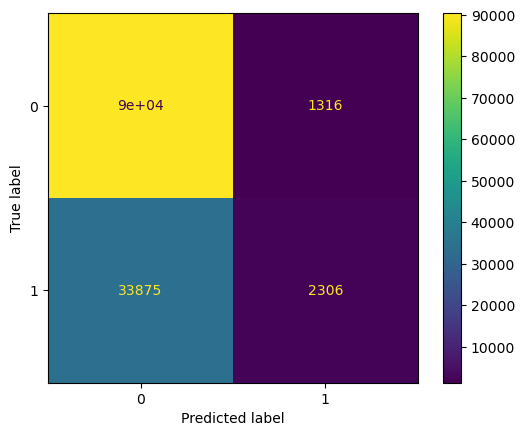

In [23]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### ML Pipeline for Best Model

In [ ]:
from pyspark.ml import Pipeline
labelIndexer = StringIndexer(inputCol="Violation_In_Front_Of_Or_Opposite_idx", outputCol="indexedLabel").fit(spark_df)

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(spark_df)


pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Case2: Target column is "Violation_Code"

In [25]:
# drop some columns 
col = ['Violation_Description_idx']
dfs = dfs.drop(*col)

In [26]:
dfs.registerTempTable('Temp70') 
Temp70 = spark.sql(r"""SELECT Violation_Code
                      FROM Temp70 """) 
Temp70 = Temp70.toPandas() 
count = Temp70.Violation_Code.value_counts().sort_values(ascending=False)
count

C:\Users\abu3a\miniconda3\lib\site-packages\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


21    181493
38    153970
37     89708
14     42173
20     41980
69     33716
16     25977
31     20730
47     18505
42     13199
24      7375
78      3937
17      3508
18      1249
23       931
89       717
39       377
35       326
13       245
26       205
19        91
4         81
43        61
10        54
46         9
33         3
40         3
48         3
70         3
71         2
32         2
44         1
25         1
68         1
Name: Violation_Code, dtype: int64

In [27]:
# the Violation Code column have 38 class, so we will reduce this by taking only the top 3 frequnt 
Violation_Code_del = dfs.groupby('Violation_Code').count().orderBy('count', ascending=True).filter("count < 50000")
Violation_Code_del = Violation_Code_del.select(Violation_Code_del.Violation_Code).rdd.flatMap(lambda x: x).collect()
dfs = dfs.filter(~(dfs.Violation_Code).isin(Violation_Code_del))

In [28]:
# Extracting the feature from the data 
target2 = list(set(dfs.columns) - {'Violation_Code'})
f2 = dfs.select(target2)
cols2 = f2.columns


assembler = VectorAssembler(inputCols=cols2, outputCol='features')
spark_df2 = assembler.setHandleInvalid("skip").transform(dfs)
df_data2 = spark_df2.select(F.col('features'), F.col('Violation_Code').alias('label'))
print((df_data2.count(), len(df_data2.columns)))

(425171, 2)


In [29]:
#Split training and Testing.
df_train2, df_test2 = df_data2.randomSplit([0.8, 0.2])

train_rows2 =df_train2.count()
test_rows2 =df_test2.count()

print("Total train :",train_rows2)
print("Total test :", test_rows2)

Total train : 340600
Total test : 84571


In [30]:
# LogisticRegression
lr2 = LogisticRegression(labelCol="label", featuresCol="features")
model_lr2 = lr2.fit(df_train2)

# Decision Tree
dt2 = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dt2 = dt2.fit(df_train2)

# Random Forest
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=15)
model_rf2 = rf2.fit(df_train2)

In [31]:
# Predictions on the testing set.
pred_lr2 = model_lr2.transform(df_test2)
pred_dt2 = model_dt2.transform(df_test2)
pred_rf2 = model_rf2.transform(df_test2)

In [32]:
# models
models2 = [pred_lr2,pred_dt2, pred_rf2]


# Empty lists that will store the scores for each metric for each model.
accuracy2 = []
F12 = []
precision2 = []
recall2 = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models2:
    accuracy2.append(evaluator_A.evaluate(model))
    F12.append(evaluator_F.evaluate(model))
    precision2.append(evaluator_P.evaluate(model))
    recall2.append(evaluator_R.evaluate(model))


df_ev2 = pd.DataFrame(list(zip(accuracy2, F12, precision2, recall2)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Logistic Regression','Decision Tree', 'Random Forest'])

df_ev2

,Accuracy,F1 score,Weighted Precision,Weighted Recall
Logistic Regression,0.833773,0.797592,0.876366,0.833773
Decision Tree,0.833312,0.794604,0.885854,0.833312
Random Forest,0.833312,0.794604,0.885854,0.833312


### Model Selection 

### We choose Logistic Regression because it has highest score in all matrices.

### Model Optimization - Hyperparameter Tuning 

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

#initialize our grid -> we are using variation with only one parameter called maxIter (maximum iteration)
grid2 = ParamGridBuilder().addGrid(lr2.maxIter, [5, 10, 15, 20]).build()

#CrossValidator will by default have 3 folds. We can explicitly specify that using numFolds = 3
cv2 = CrossValidator(estimator=lr2, estimatorParamMaps=grid2, evaluator=evaluator_A, parallelism=2)

#lets fit again on our training set
cvModel2 = cv2.fit(df_train2)
pred_cvModel2 = cvModel2.transform(df_test2)


In [35]:
y_true2 = pred_cvModel2.select(['label']).collect()
y_pred2 = pred_cvModel2.select(['prediction']).collect()

print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

          21       1.00      1.00      1.00     36079
          37       0.88      0.25      0.39     17867
          38       0.69      0.98      0.81     30625

    accuracy                           0.83     84571
   macro avg       0.86      0.74      0.73     84571
weighted avg       0.86      0.83      0.80     84571



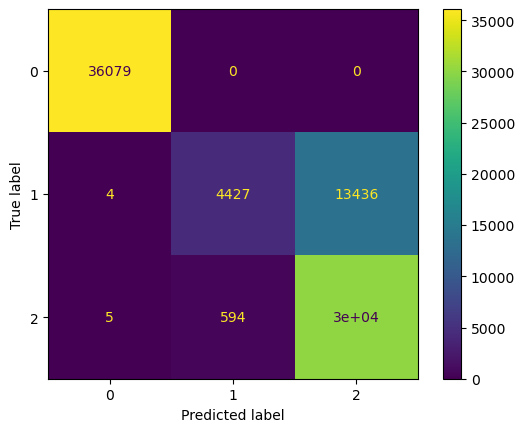

In [36]:
cm2 = confusion_matrix(y_true2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()